<a href="https://colab.research.google.com/github/flo20schae/data-sience-fundamentals/blob/main/11_Basic_Image_Processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 11. Basic Image Processing: Filtering, scaling, thresholding

## Loading

A lot of data come as images or can be transformed into images, e.g microscope images, phone images, videos, spectrograms of speach and music and so on. Consequently automatic image processing is very important in many research domains. 

Python and Numpy have very powerful image processing capabilities. This is natural since an image is nothing but a table/array of pixels with some value in each pixel. All the linear algebra power of Numpy can then be applied. 

Almost all image processing pipelines start with some basic procedures like thresholding, scaling, or projecting a multi-dimensional image.

Let us import again all necessary packages (the package skimage is new to us):

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
# from skimage.external.tifffile import TiffFile


Most filtering functions will come out from the filters module of scikit-image:

In [ ]:
import skimage.filters as skf

A specific region size/shape has often to be specified for filters. Those are defined in the morphology module:

In [ ]:
import skimage.morphology as skm

Additionally, this module offers a set of binary operators essential to operate on the masks resulting from segmentation.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# We need to convert the image HEIC formats to something more usual. Stack overflow suggests to use PIL for that. So we installs that.
!pip install pillow_heif 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 25.2 MB/s eta 0:00:00


In [ ]:
# Convert the image to png - code from stack overflow
from PIL import Image
import pillow_heif

url_pre  = '/content/drive/MyDrive/DSF/'
url_name = 'IMG_5387.heic'
heif_file = pillow_heif.read_heif(url_pre+url_name)
image = Image.frombytes(heif_file.mode,heif_file.size,heif_file.data.tobytes(),"raw",)
url_name = url_name.split('.')[0]+'.png'
image.save(url_pre+url_name, format="png")

## Exploring an image

(4032, 3024, 3) (4032, 3024)


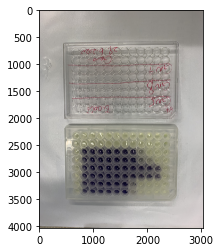

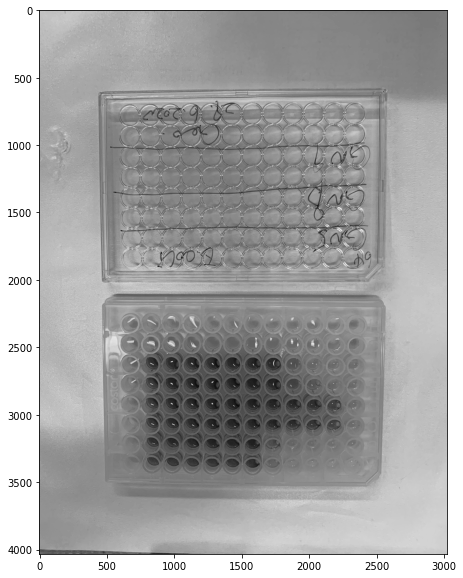

In [ ]:
#load image and show the B channel
imageRGB  = io.imread(url_pre+url_name)
plt.imshow(imageRGB)
image = imageRGB[:,:,2]
print(imageRGB.shape,image.shape)
#plot image
plt.figure(figsize=(10,10))
plt.imshow(image,cmap = 'gray')
plt.show()

This is an image of some chemical solutions. Our ultimate goal is to write an algorithm which can automatically count the colored bins. If you want to know why, ask Sasha.

In [ ]:
# Let's study the image a bit further
print(type(image))
print(image.dtype)
image


<class 'numpy.ndarray'>
uint8


array([[187, 187, 193, ..., 126, 126, 126],
       [187, 187, 193, ..., 126, 126, 126],
       [187, 187, 193, ..., 126, 126, 126],
       ...,
       [102, 102, 104, ..., 199, 199, 199],
       [100, 100, 102, ..., 195, 195, 195],
       [ 99,  99, 101, ..., 195, 195, 195]], dtype=uint8)

In [ ]:
# As the image is a numpy array, we could to arithmetics on it, e.g.
print(image/2, image.shape,image.max(), image.min())

[[93.5 93.5 96.5 ... 63.  63.  63. ]
 [93.5 93.5 96.5 ... 63.  63.  63. ]
 [93.5 93.5 96.5 ... 63.  63.  63. ]
 ...
 [51.  51.  52.  ... 99.5 99.5 99.5]
 [50.  50.  51.  ... 97.5 97.5 97.5]
 [49.5 49.5 50.5 ... 97.5 97.5 97.5]] (4032, 3024) 255 0


(2016, 3024)


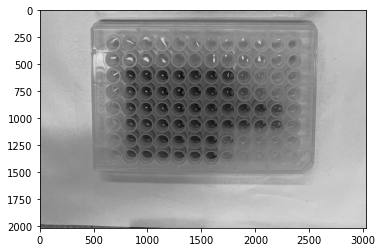

In [ ]:
# We are only interested in the lower part, so let's do a crop
image = image[image.shape[0]//2:image.shape[0],:]
print(image.shape)
plt.imshow(image, cmap ='gray')
plt.show()

## Filtering

A large set of filters are offered in scikit-image. Filtering is a local operation, where a value is calculated for each pixel and its surrounding region according to some function. For example a median filter of size 3, calculates for each pixel the median value of the 3x3 region around it.

Most filters take as input a specified region to consider for the calculation (e.g. 3x3 region). Those can be defined using the morphology module.

<ipython-input-27-7352a490cef6>:2: FutureWarning: `selem` is a deprecated argument name for `median`. It will be removed in version 1.0. Please use `footprint` instead.
  image_mean = skf.median(image,selem=skm.disk(20))


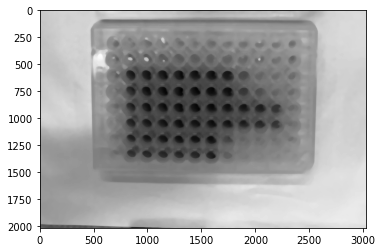

In [ ]:
# There are some reflections or white dots in the black bins. Let's try to get rid of them with a filter.
image_mean = skf.median(image,selem=skm.disk(20))
plt.imshow(image_mean, cmap ='gray')
plt.show()

## Thresholding

Another common operation is to try isolating regions of an image based on their intensity by using an intensity threshold: one can create a mask object where all values larger than a threshold are 1 and the other 0. It is usually better to use a smoothed version of the image (e.g. median or gaussian filtering) to avoid including noisy pixels in the mask.


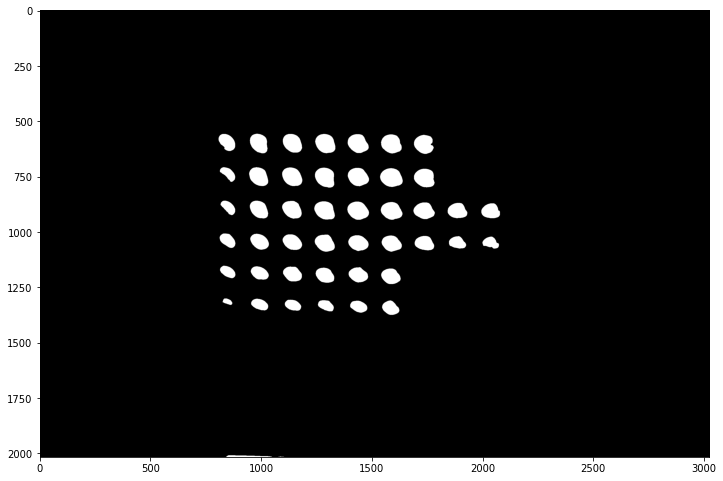

In [ ]:
threshold_manual = 60

#create a mask using a logical operation
image_threshold = image_mean<threshold_manual

plt.figure(figsize=(12, 12))
plt.imshow(image_threshold, cmap ='gray')
plt.show()

In [ ]:
# Let us play with the threshold iteractively to find a good value
#from ipywidgets import interact
from ipywidgets import *

def update(threshold_manual = 120):
  image_threshold = image_mean<threshold_manual
  plt.figure(figsize=(12, 12))
  plt.imshow(image_threshold, cmap ='gray')
  plt.show()

interact(update);

interactive(children=(IntSlider(value=120, description='threshold_manual', max=360, min=-120), Output()), _dom…

Around 60 seems to be a good threshold. Now we would like to count the bins. This is part of the challenge in coding task 2.

## Rescaling

A very common operation to do in an image processing pipeline, is to rescale the intensity of images. The reason can be diverse: for example, one might want to remove an offset added to each pixel by the camera, or one might want to homogenize multiple images with slightly varying exposures.

The simplest thing to do is to rescale from min to max in the range 0-1:

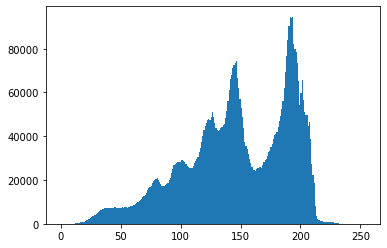

min val: 4
max val: 255


In [ ]:
# Let's first look at the intensity distribution of the image.
plt.hist(np.ravel(image), bins = np.arange(0,255)) # np.ravel flattens image into 1D array
plt.show()
print("min val: "+ str(np.min(image)))
print("max val: "+ str(np.max(image)))

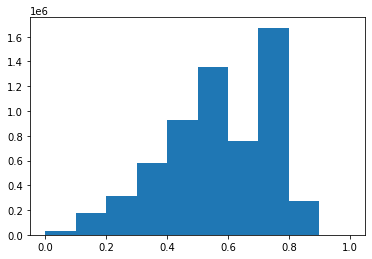

In [ ]:
# Normalize the pixelvalues to be between 0 and 1
image_minmax = (image-image.min())/(image.max()-image.min())
image_minmax[image_minmax>1] = 1
plt.hist(np.ravel(image_minmax))
plt.show()

## Further Notes


Image processing is a large field. There is not space to cover all topics in this course, for example segmentation, classification etc. The purpose has been to get us used to think of images as numpy arrays and do basic operations on them.  